### Stock Forecaster

In [1]:
from lib.forecast import StockForecaster
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sf = StockForecaster(epochs=100)
sf.load("AAPL.csv")
sf.prepare()
sf.create_model()

In [3]:
sf.raw_data.head(4)

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600


<Axes: xlabel='Date'>

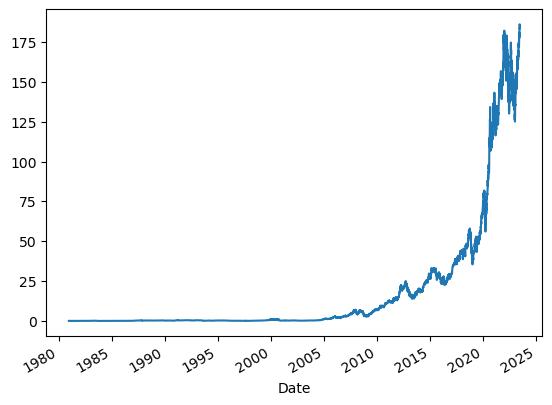

In [4]:
sf.raw_data["Close"].plot()

#### Train Model

In [5]:
loss_data, test_loss_data = sf.train()

Epoch: 0, train loss: 0.008288159966468811, test loss: 0.43380114436149597


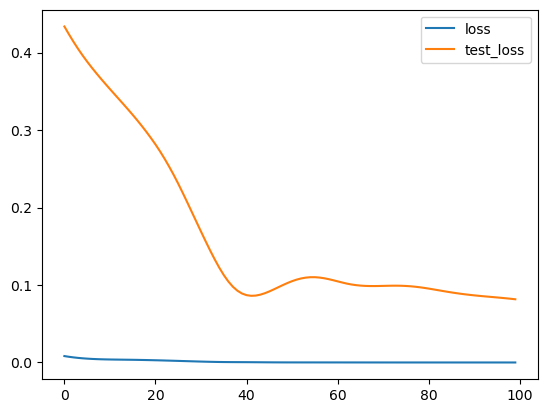

In [6]:
plt.plot(loss_data, label="loss")
plt.plot(test_loss_data, label="test_loss")
plt.legend()
plt.show()

#### Validate

In [7]:
test_data = sf.ss.inverse_transform(sf.X_test_tensors.data.numpy()[:,-1])
train_predict = sf.lstm(sf.X_test_tensors) 
data_predict = sf.mm.inverse_transform(train_predict.data.numpy())
sf.train_samples, sf.test_samples, len(train_predict.data.numpy())

(9647, 1072, 1072)

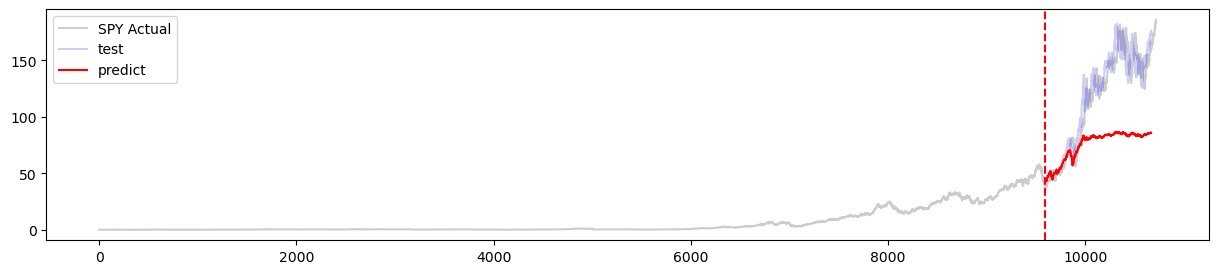

In [8]:
plt.figure(figsize=(15,3)) #plotting
plt.plot(sf.mm.inverse_transform(sf.y_train), "k", label="SPY Actual", alpha=0.2)

td = [None] * (sf.train_samples - 50)
td.extend(test_data[:,0])
plt.plot(td, "b", label="test", alpha=0.2)

dp = [None] * (sf.train_samples - 50)
dp.extend(data_predict[:,0])
plt.plot(dp, "r", label="predict")

plt.axvline(x=sf.train_samples-50, c='r', linestyle='--') # size of the training set

plt.legend()
plt.show()

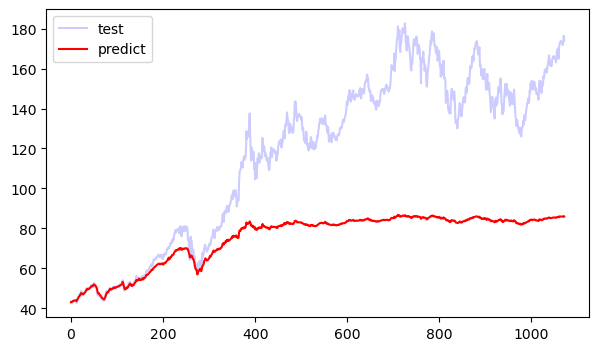

In [9]:
plt.figure(figsize=(7,4)) #plotting

td = test_data[:,0]
plt.plot(td, "b", label="test", alpha=0.2)

dp = data_predict[:,0]
plt.plot(dp, "r", label="predict")

plt.legend()
plt.show()

### Future Price

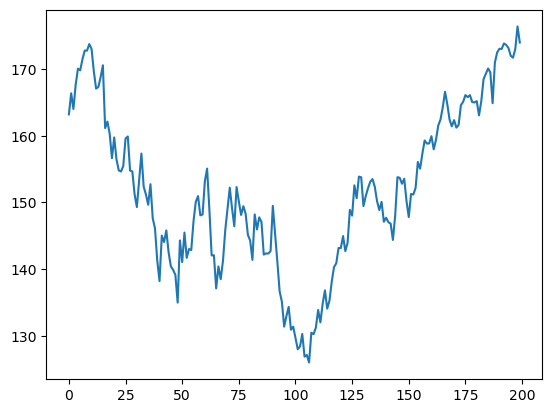

In [10]:
ds = sf.X_test_tensors[-1].unsqueeze(0)
plt.plot(sf.ss.inverse_transform(ds.detach().numpy()[0])[:, 0])

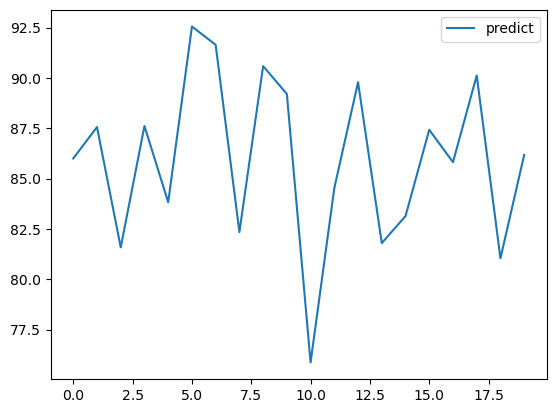

In [11]:
test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = sf.y_test_tensors[-1].detach().numpy() # last sample again
test_target = sf.mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_predict, label="predict")
# plt.plot(test_target, label="actual")
plt.legend()
plt.show()